# Metrics during GRACE era: Decomposition

In this notebook, we decompose the GRACE-era predictions into linear trend and multiple seasonal components. The signal components of our reconstruction and GRACE, the target, are compared.

In [1]:
from typing import Literal

import cmcrameri.cm as cmc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xarray as xr
from dask.diagnostics import ProgressBar
from matplotlib import ticker
from matplotlib_inline.backend_inline import set_matplotlib_formats

import deeprec  # noqa
from deeprec import metrics
from deeprec.regions import basins
from deeprec.utils import ROOT_DIR, month_center_range

# Register dask progress bar
ProgressBar(minimum=5).register()

In [2]:
set_matplotlib_formats("retina")
plt.style.use(ROOT_DIR / "config/style_paper.mplstyle")
FIGURE_DIR = ROOT_DIR / "figures/si"


Open model predictions:

In [3]:
# Load and combine our predictions
pred_dir = ROOT_DIR / "models/predictions/ensemble-mixed"

ours_list = []

for inp_name in ["era", "era-rdcd", "wghm-era"]:
    twsa_ours = xr.open_zarr(pred_dir / f"ensemble-mixed_{inp_name}_best-mae.zarr").twsa
    ours_list.append(twsa_ours.rename(f"twsa_ours_{inp_name}"))
ours = xr.merge(ours_list)


In [4]:
targets_store = ROOT_DIR / "data/processed/targets.zarr"
inputs_store = ROOT_DIR / "data/processed/inputs.zarr"
recs_store = ROOT_DIR / "data/processed/reconstructions.zarr"

tgts = xr.open_zarr(targets_store)
inps = xr.open_zarr(inputs_store)
recs = xr.open_zarr(recs_store)

In [5]:
# Merge all data sets
ds_all = xr.merge([tgts, inps, ours, recs])

# Create and apply mask (land area and Greenland+Antarctica exclusion)
mask = (tgts.land_mask_jpl * tgts.land_mask_gsfc * inps.grl_ata_mask).compute()
ds_all = ds_all.where(mask == 1)

# Substract the GRACE baseline
baseline = slice("2004", "2009")
base_mean = ds_all.sel(time=baseline).mean("time")
ds_all = ds_all - base_mean


Specify variables of interest and their descriptive names:

In [6]:
names_verbose = {
    "twsa_ours_era": "DeepRec",
    "twsa_ours_wghm-era": "DeepRec, w/ WGHM",
    "twsa_gap": "WGHM",
    "humphrey_gsfc_detrend": "Humphrey's GSFC Rec",
    "li_csr_full": "Li's CSR Rec",
    "yin_csr_full": "Yin's CSR Rec",
    "palazzoli_jpl_full": "Palazzoli's JPL Rec",
    "twsa_csr": "CSR (GRACE)",
}
eval_names = list(names_verbose.keys())

target_name = "twsa_csr"
eval_names.remove(target_name)


## Trends and amplitudes during GRACE era

In [7]:
ds_grid = ds_all[[target_name, *eval_names]]
# Only evaluate GRACE time
ds_grid = ds_grid.sel(time=slice("2002", "2023")).compute()
# Remove missing time steps - remove missing time steps in GRACE for all vars
ds_grid = ds_grid.where(ds_grid.dr.time_notnull(), drop=True)
print(len(ds_grid.time))
# Calculate basin averages
ds_basin: xr.Dataset = (
    # Select variables and time frame of interest
    ds_grid.chunk(time=10, lat=-1, lon=-1)
    .dr.select_basins(top=72)
    .dr.weight_lat()
    .mean(["lat", "lon"])
    .compute()
)


[########################################] | 100% Completed | 9.42 s
159
[########################################] | 100% Completed | 69.22 s


In [8]:
times = ds_grid.get_index("time")
print(f"Timespan: {times[0].date()} to {times[-1].date()}")


Timespan: 2002-04-01 to 2019-07-01


In [9]:
# Convert to data arrays
da_grid = ds_grid.to_dataarray("model")
da_basin = ds_basin.to_dataarray("model")


### Perform linear trend / multi-seasonal decomposition

We use the following function to approximate the constant $a$, the linear trend $m$, and the annual and semiannual sinusoidal curves:

$$
y(t) = a + m \, t + c \, \sin(2π  \, t) + d \, \cos(2π \, t) + e \, \sin(4π \, t) + f \cos(4π \, t) + r
$$

In [10]:
YEAR_NS = 365.25 * 24 * 60 * 60 * 1e9


def decomp_func(
    t: np.ndarray, a: float, b: float, c: float, d: float, e: float, f: float
) -> np.ndarray:
    # Convert t from nanosecons to years
    t = t / YEAR_NS

    linear = a + b * t
    annual = c * np.sin(2 * np.pi * t) + d * np.cos(2 * np.pi * t)
    semian = e * np.sin(4 * np.pi * t) + f * np.cos(4 * np.pi * t)

    return linear + annual + semian


In [11]:
# Apply decomposition
# Curvefit skips missing values per default
fit = da_basin.curvefit("time", decomp_func)


Evaluate result:

In [12]:
# Only perform analysis on GRACE TWSA and Congo
csr = tgts.twsa_csr
twsa_congo_orig = (
    csr.dr.select_basins("Congo", return_region=False)
    .dr.weight_lat()
    .mean(["lat", "lon"])
)

# Obtain curvefit coefficients
fit_coeff = twsa_congo_orig.curvefit("time", decomp_func).curvefit_coefficients
# Create time series without missing values
time_csr = twsa_congo_orig.get_index("time")
time_full = month_center_range(time_csr[0], time_csr[-1])
# # Convert time stamps to nanoseconds
t = time_full.values.astype(float)
twsa_congo_linrec = decomp_func(t, *fit_coeff.values)
# # Create a data array from it
twsa_congo_linrec = xr.DataArray(
    twsa_congo_linrec, dims=["time"], coords={"time": time_full}, name="twsa_csr_linrec"
)


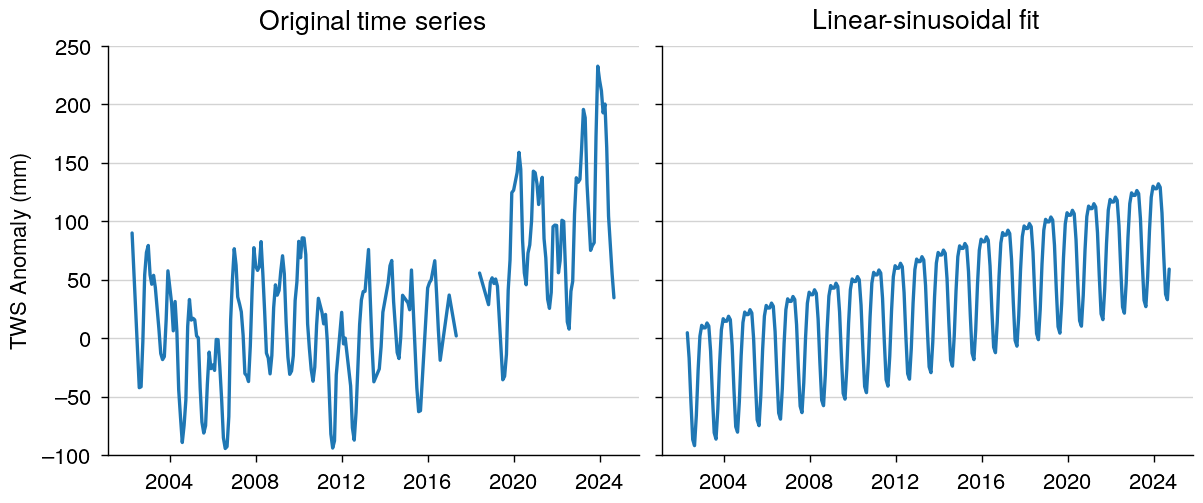

In [13]:
fig, ax = plt.subplots(ncols=2, figsize=(6, 2.5), sharex=True, sharey=True)
ax1, ax2 = ax
ax1.plot(twsa_congo_orig.time, twsa_congo_orig)
ax2.plot(twsa_congo_linrec.time, twsa_congo_linrec)
ax1.set(ylim=(-100, 250), title="Original time series", ylabel="TWS Anomaly (mm)")
ax2.set(title="Linear-sinusoidal fit")
ax1.yaxis.grid(True)
ax2.yaxis.grid(True)


### Calculate slope and amplitudes

In [14]:
# Linear trend: mm / yr
da_lintrend = fit.curvefit_coefficients.sel(param="b")

da_lintrend.attrs = {"long_name": "Trend", "unit": "mm / yr"}


Calculate annual amplitude:

$$
A = \sqrt{c^2 + d^2}
$$

In [15]:
c = fit.curvefit_coefficients.sel(param="c")
d = fit.curvefit_coefficients.sel(param="d")
e = fit.curvefit_coefficients.sel(param="e")
f = fit.curvefit_coefficients.sel(param="f")

da_amp_annual = np.sqrt(c**2 + d**2)
da_amp_semian = np.sqrt(e**2 + f**2)

da_amp_annual.attrs = {"long_name": "Annual amplitude", "unit": "mm"}
da_amp_semian.attrs = {"long_name": "Semiannual amplitude", "unit": "mm"}


### Scatter plots

In [16]:
# GeoDataFrame containing basin shapes and areas
gdf_basin_shapes = basins(top=72)

# Series of basin areas, for scatter plotting
s_basin_areas = gdf_basin_shapes.rename(
    columns={"riverbasin": "region", "sum_sub_ar": "area"}
).set_index("region")["area"]

# DataArray of basin areas, for weighting
da_basin_areas = xr.DataArray.from_series(s_basin_areas)


In [17]:
# Place components in dictionaries for easier batch handling
da_comps = {
    "lintrend": da_lintrend,
    "amp_annual": da_amp_annual,
    "amp_semian": da_amp_semian,
}
df_comps = {}
pcc_scores = {}

for name, da in da_comps.items():
    # Convert DataArrays to DataFrames for plotting with Seaborn
    df = (
        da.to_pandas()
        .transpose()
        .reset_index()
        # Add basin size column (in Million km)
        .merge(s_basin_areas / 1e6, on="region")
        # Create name and value columns of model twsas
        .melt(
            id_vars=["region", target_name, "area"],
            value_name="twsa_model",
            var_name="model",
        )
        # Sort after area so large basins are printed lastly
        .sort_values("area")
    )
    df.model = pd.Categorical(df.model, categories=eval_names, ordered=True)
    df_comps[name] = df

    # Calculate PCC
    pcc_scores[name] = metrics.pearson_r(
        da.sel(model=target_name),
        da.drop_sel(model=target_name),
        weights=da_basin_areas,
    )


In [18]:
print(f"{da_lintrend.min() = :.2f}")
print(f"{da_lintrend.max() = :.2f}")

print(f"{da_amp_annual.min() = :.2f}")
print(f"{da_amp_annual.max() = :.2f}")

print(f"{da_amp_semian.min() = :.2f}")
print(f"{da_amp_semian.max() = :.2f}")


da_lintrend.min() = -27.57
da_lintrend.max() = 9.91
da_amp_annual.min() = 2.50
da_amp_annual.max() = 228.86
da_amp_semian.min() = 0.35
da_amp_semian.max() = 65.55


In [19]:
# Limits
lims = {
    "lintrend": (-30, 20),
    "amp_annual": (0, 250),
    "amp_semian": (0, 80),
}
# Major locators
locs = {
    "lintrend": ticker.MultipleLocator(10),
    "amp_annual": ticker.MultipleLocator(50),
    "amp_semian": ticker.MultipleLocator(20),
}


In [20]:
# Units
units = {
    "lintrend": "mm yr$^-1$",
    "amp_annual": "mm",
    "amp_semian": "mm",
}
# Verbose names
comp_names = {
    "lintrend": "Linear trend",
    "amp_annual": "Annual amplitude",
    "amp_semian": "Semiannual amplitude",
}


Create function to automate scatterplotting:

In [21]:
def plot_scatter(
    comp: Literal["lintrend", "amp_annual", "amp_semian"],
) -> plt.Figure:
    # Unpack dicts
    df_comp = df_comps[comp]
    comp_verbose = comp_names[comp]
    unit = units[comp]
    lim = lims[comp]
    loc = locs[comp]
    pcc = pcc_scores[comp]

    p = sns.relplot(
        df_comp,
        x=target_name,
        y="twsa_model",
        col="model",
        size="area",
        col_wrap=2,
        height=2,
        aspect=1,
    )

    for ax, model in zip(p.axes.flat, df_comp.model.cat.categories):
        # Add separator line
        ax.plot(
            lim,
            lim,
            color="gray",
            linestyle="dashed",
            linewidth=0.8,
            zorder=0.0,
        )

        # Add score
        ax.text(
            1.0,
            0.07,
            f"PCC = {pcc.sel(model=model):.2f}",
            ha="right",
            transform=ax.transAxes,
        )

        ax.set(
            title=names_verbose[model],
            xlim=lim,
            ylim=lim,
            xlabel=None,
            ylabel=None,
            aspect="equal",
        )
        ax.xaxis.set_major_locator(loc)
        ax.yaxis.set_major_locator(loc)
        ax.xaxis.grid(True)
        ax.yaxis.grid(True)

    sns.move_legend(
        p,
        title="Area\n" + r"($10^6$ km$^2$)",
        loc="center right",
        bbox_to_anchor=(1.05, 0.5),
    )

    # Set common labels
    p.figure.text(0.5, 0.01, f"{comp_verbose} GRACE ({unit})", ha="center")
    p.figure.text(
        0.05,
        0.5,
        f"{comp_verbose} model ({unit})",
        va="center",
        rotation="vertical",
    )
    return p.figure

c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


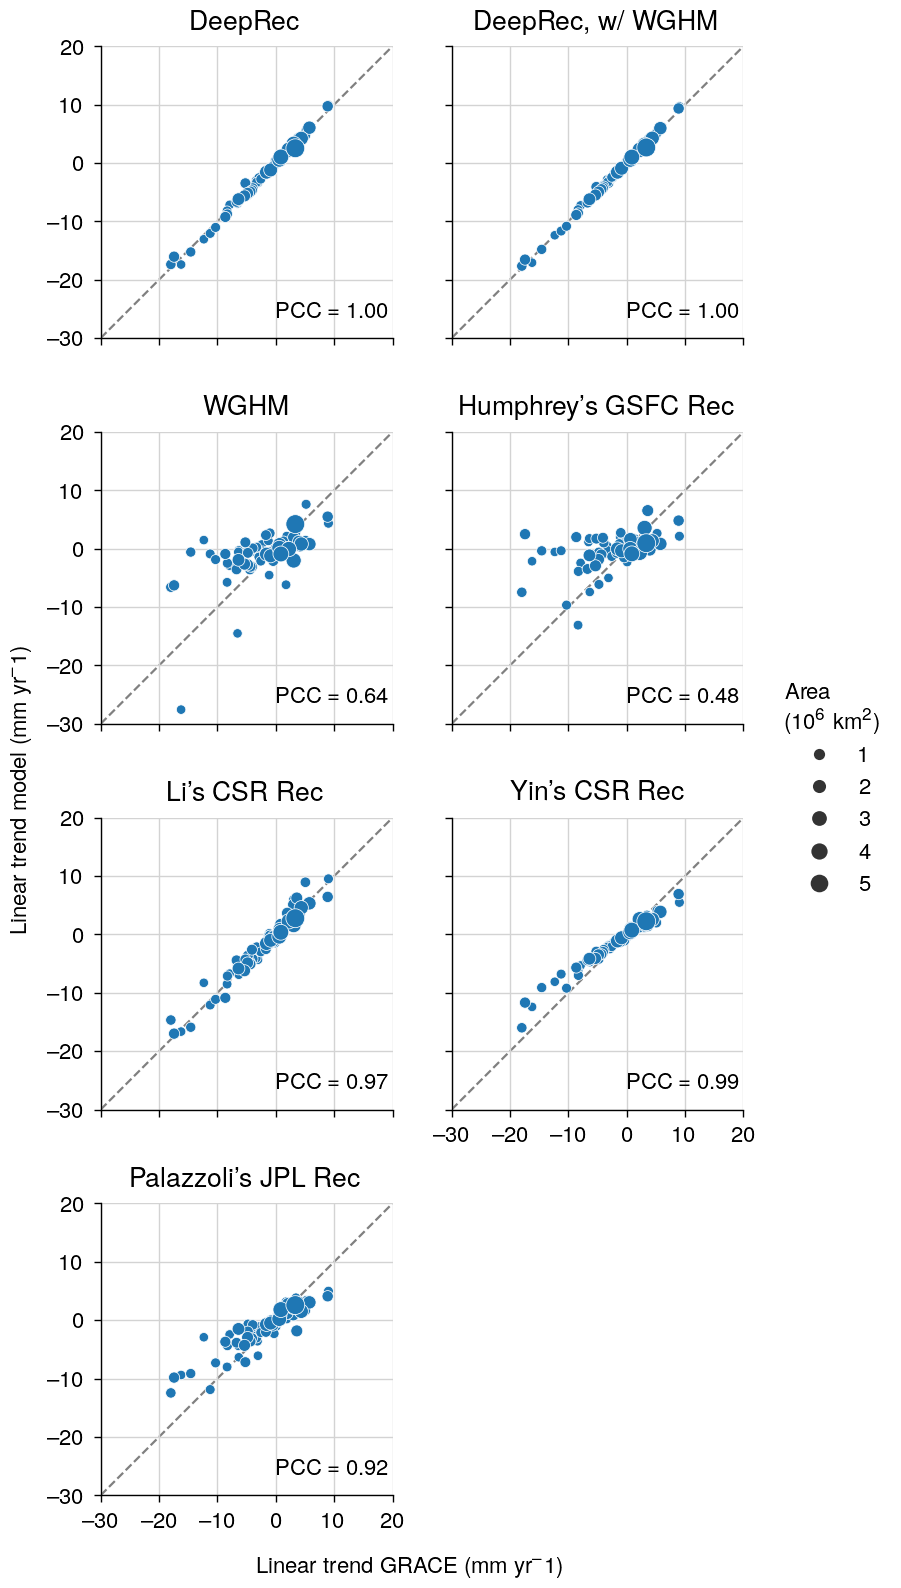

In [22]:
fig = plot_scatter("lintrend")
fig.savefig(FIGURE_DIR / "decomp_grace-era_trend_scatter.pdf", backend="pgf")


c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


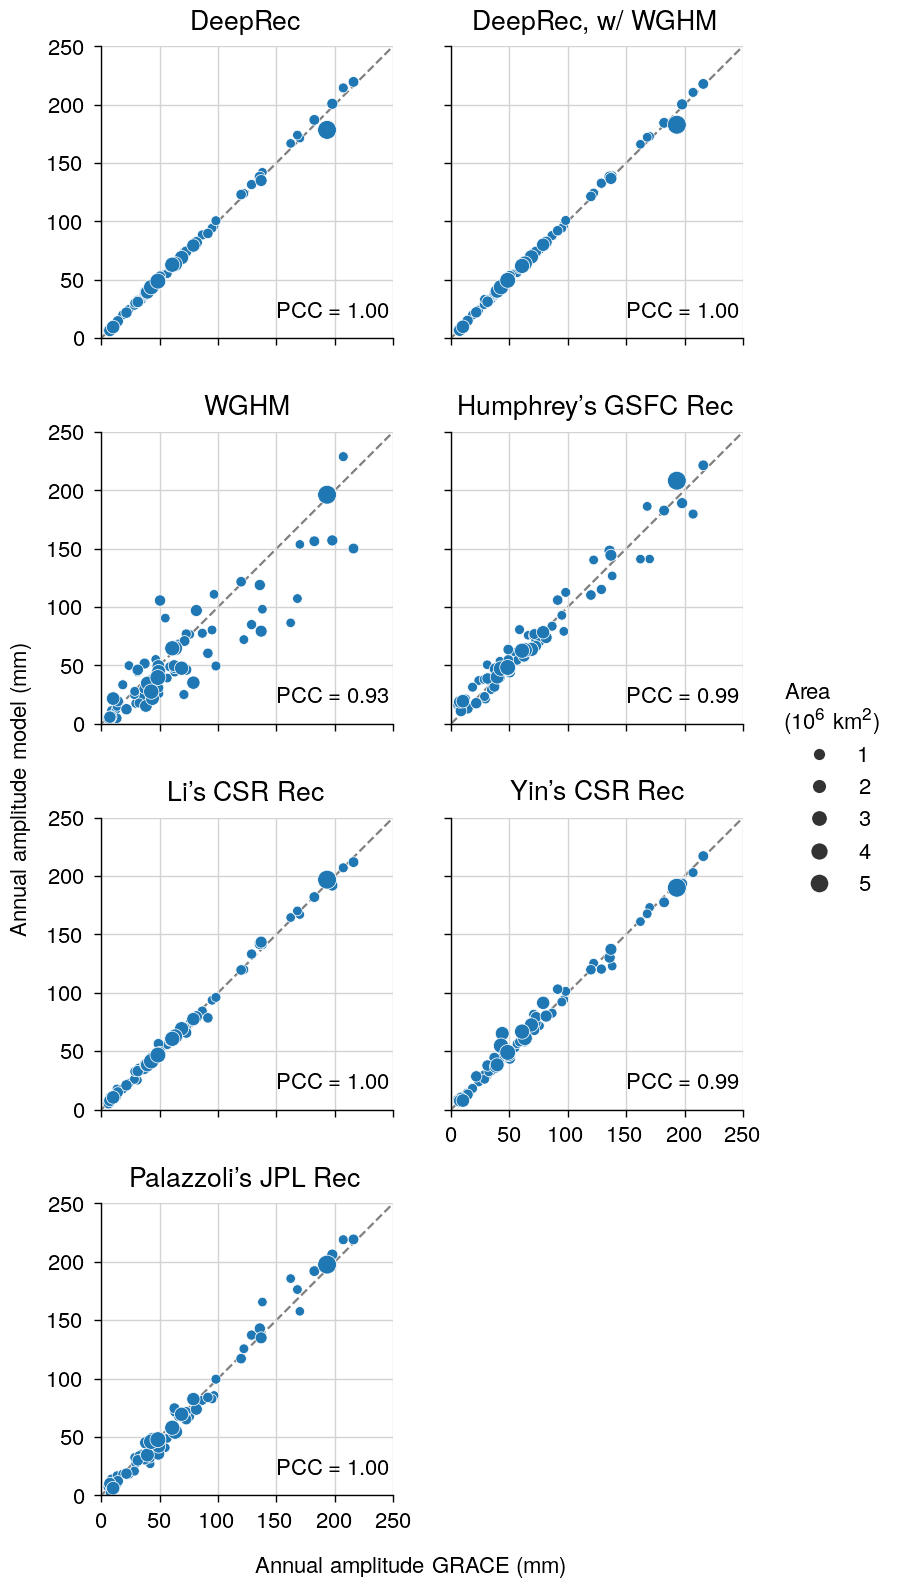

In [23]:
fig = plot_scatter("amp_annual")
fig.savefig(FIGURE_DIR / "decomp_grace-era_amp-annual_scatter.pdf", backend="pgf")

c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


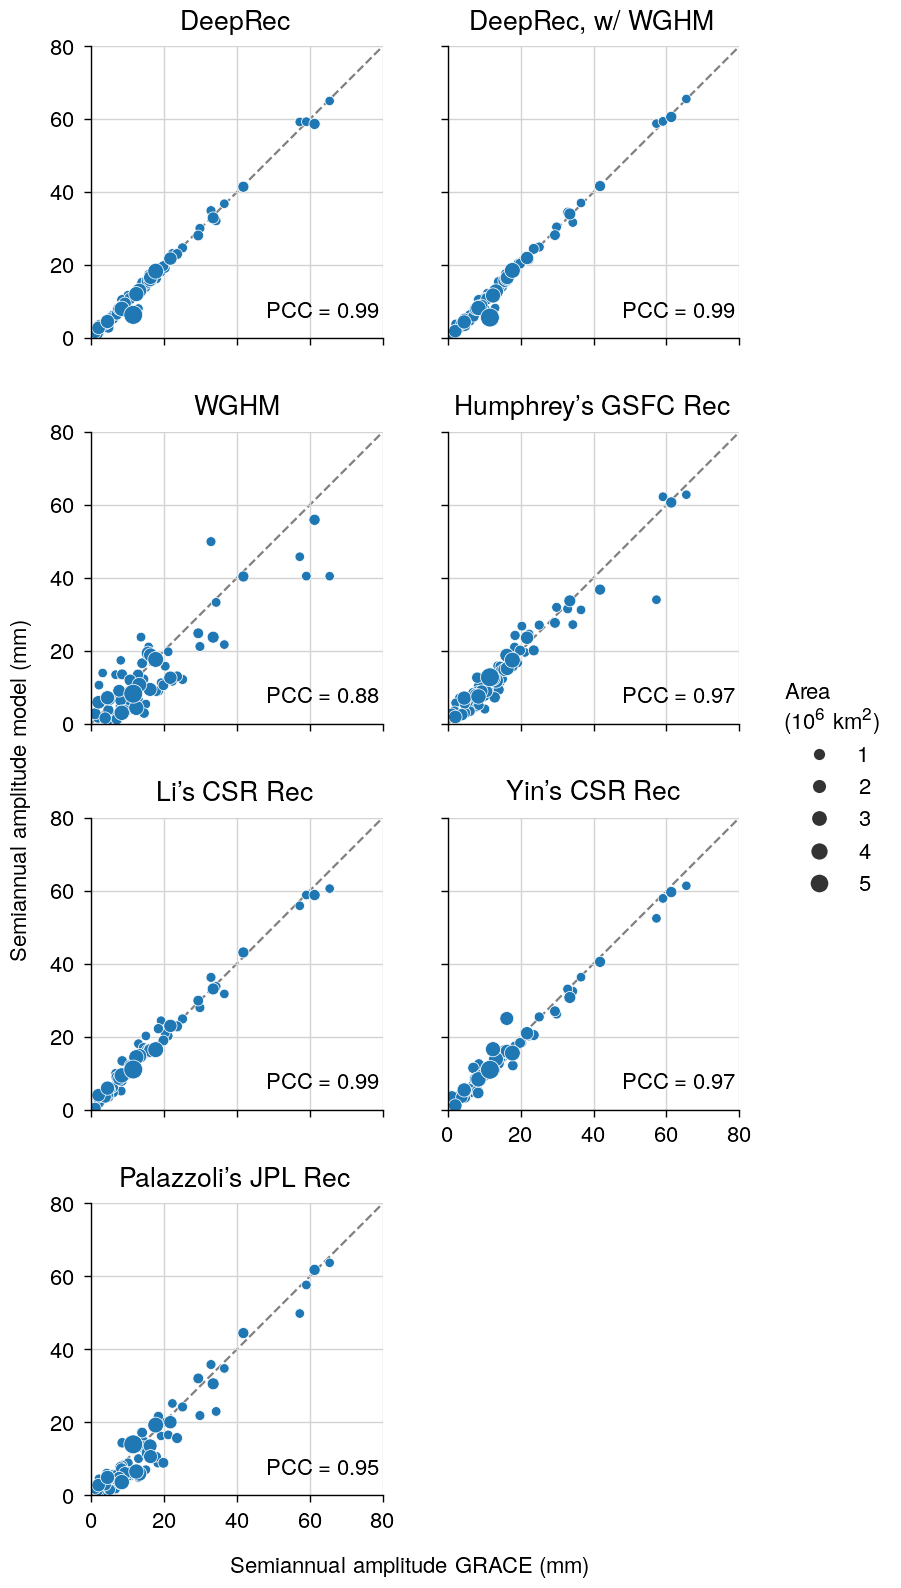

In [24]:
fig = plot_scatter("amp_semian")
fig.savefig(FIGURE_DIR / "decomp_grace-era_amp-semiannual_scatter.pdf", backend="pgf")


### Deviations

In [25]:
plot_kwargs = dict(
    col_wrap=2,
    coastlines=True,
    gridlines=True,
    rasterized=True,
    coastlines_kwargs=dict(rasterized=True, linewidth=0.5),
    cbar_kwargs=dict(location="bottom", aspect=50, shrink=0.8, pad=0.02),
    figsize=(6, 8.25),
)
basinlines_kwargs = dict(
    edgecolor="black", linewidth=0.3, facecolor="None", rasterized=True, zorder=3.0
)
title_kwargs = dict(fontsize=16, weight="bold")


In [26]:
lintrend_diff = da_lintrend.sel(model=eval_names) - da_lintrend.sel(model=target_name)
amp_annual_ratio = da_amp_annual.sel(model=eval_names) / da_amp_annual.sel(
    model=target_name
)
amp_semian_ratio = da_amp_semian.sel(model=eval_names) / da_amp_semian.sel(
    model=target_name
)


In [27]:
print(f"{lintrend_diff.max() = :.2f}")
print(f"{lintrend_diff.min() = :.2f}")


lintrend_diff.max() = 19.91
lintrend_diff.min() = -11.35


c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\xarray\plot\facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


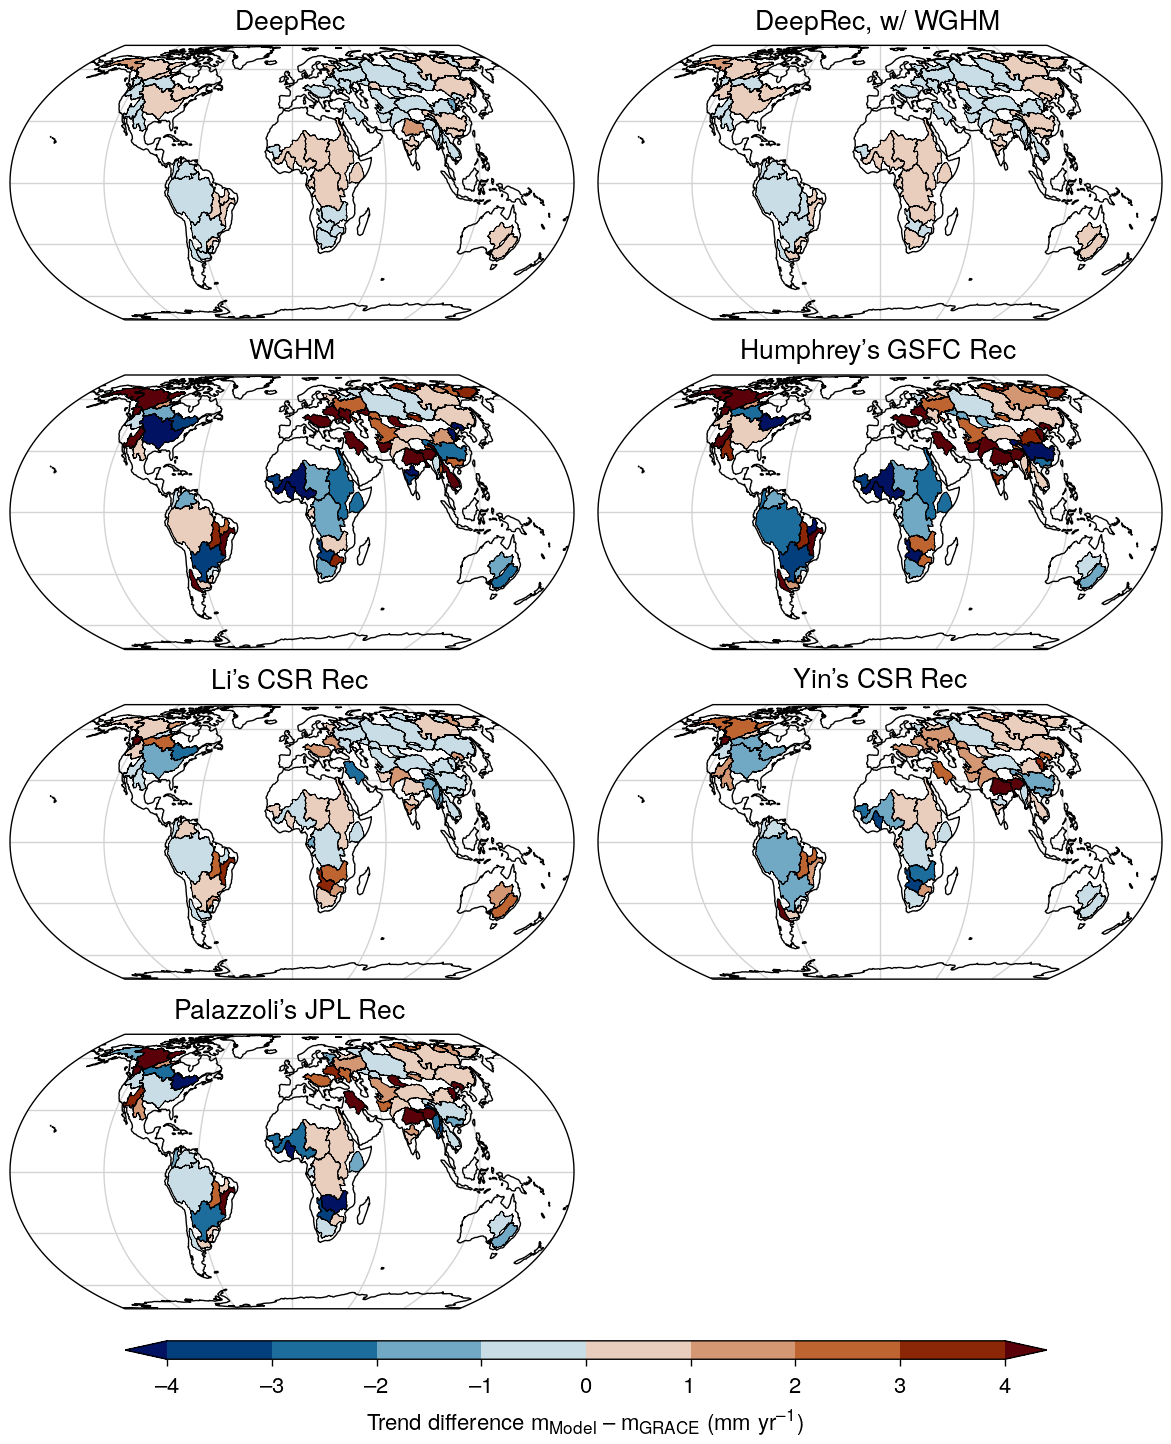

In [28]:
plot_kwargs["cbar_kwargs"]["label"] = (
    r"Trend difference $m_\text{Model} - m_\text{GRACE}$ (mm yr$^{-1}$)"
)
p = lintrend_diff.dr.projplot_basins(
    da_grid.drop_sel(model=target_name),
    col="model",
    cmap=cmc.vik,
    vmax=4,
    levels=9,
    **plot_kwargs,
)

for ax, model in zip(p.axs.flat, lintrend_diff.model.values):
    ax.set_title(names_verbose[model])
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(FIGURE_DIR / "decomp_grace-era_trend_diff.pdf", backend="pgf")


In [29]:
print(f"{amp_annual_ratio.max() = :.2f}")
print(f"{amp_annual_ratio.min() = :.2f}")


amp_annual_ratio.max() = 2.54
amp_annual_ratio.min() = 0.31


c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\xarray\plot\facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


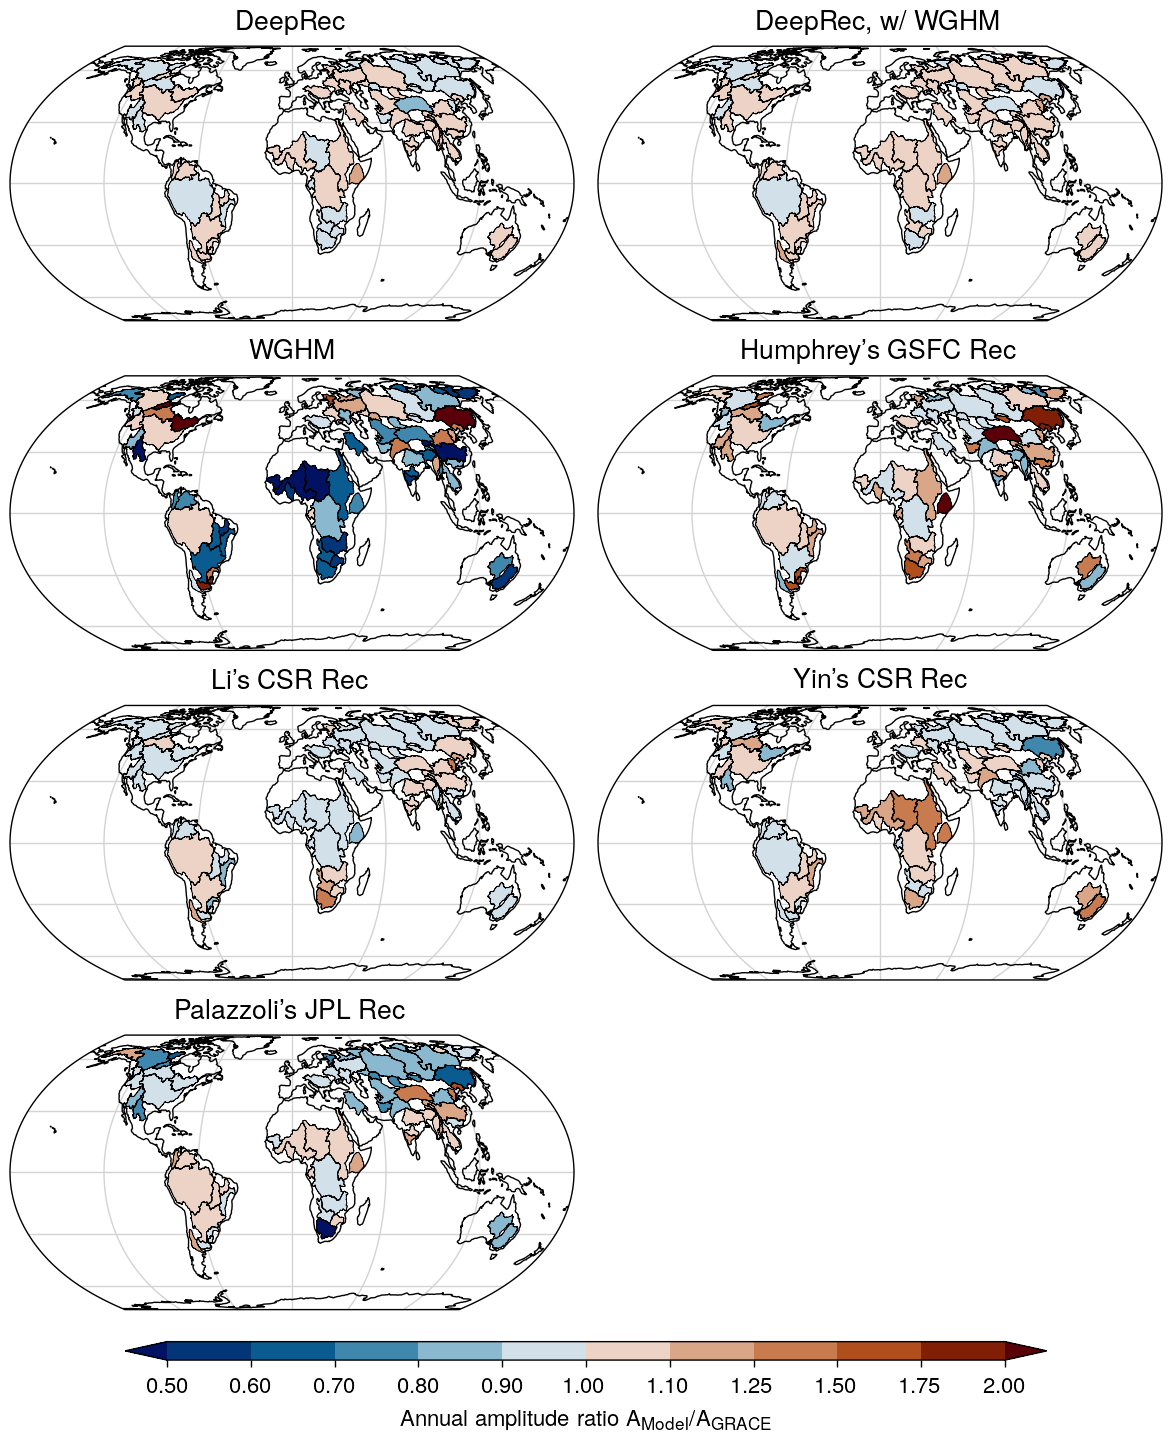

In [30]:
plot_kwargs["cbar_kwargs"]["label"] = (
    r"Annual amplitude ratio $A_\text{Model} / A_\text{GRACE}$"
)
levels = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.25, 1.5, 1.75, 2.0]

plot_kwargs["cbar_kwargs"]["ticks"] = levels

p = amp_annual_ratio.dr.projplot_basins(
    da_grid.drop_sel(model=target_name),
    col="model",
    cmap=cmc.vik,
    levels=levels,
    **plot_kwargs,
)

for ax, model in zip(p.axs.flat, amp_annual_ratio.model.values):
    ax.set_title(names_verbose[model])
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(FIGURE_DIR / "decomp_grace-era_amp-annual_ratio.pdf", backend="pgf")


In [31]:
print(f"{amp_semian_ratio.max() = :.2f}")
print(f"{amp_semian_ratio.min() = :.2f}")


amp_semian_ratio.max() = 4.81
amp_semian_ratio.min() = 0.18


c:\Users\luisg\Repositories\deeprec\.venv\Lib\site-packages\xarray\plot\facetgrid.py:680: UserWarning: The figure layout has changed to tight
  self.fig.tight_layout()


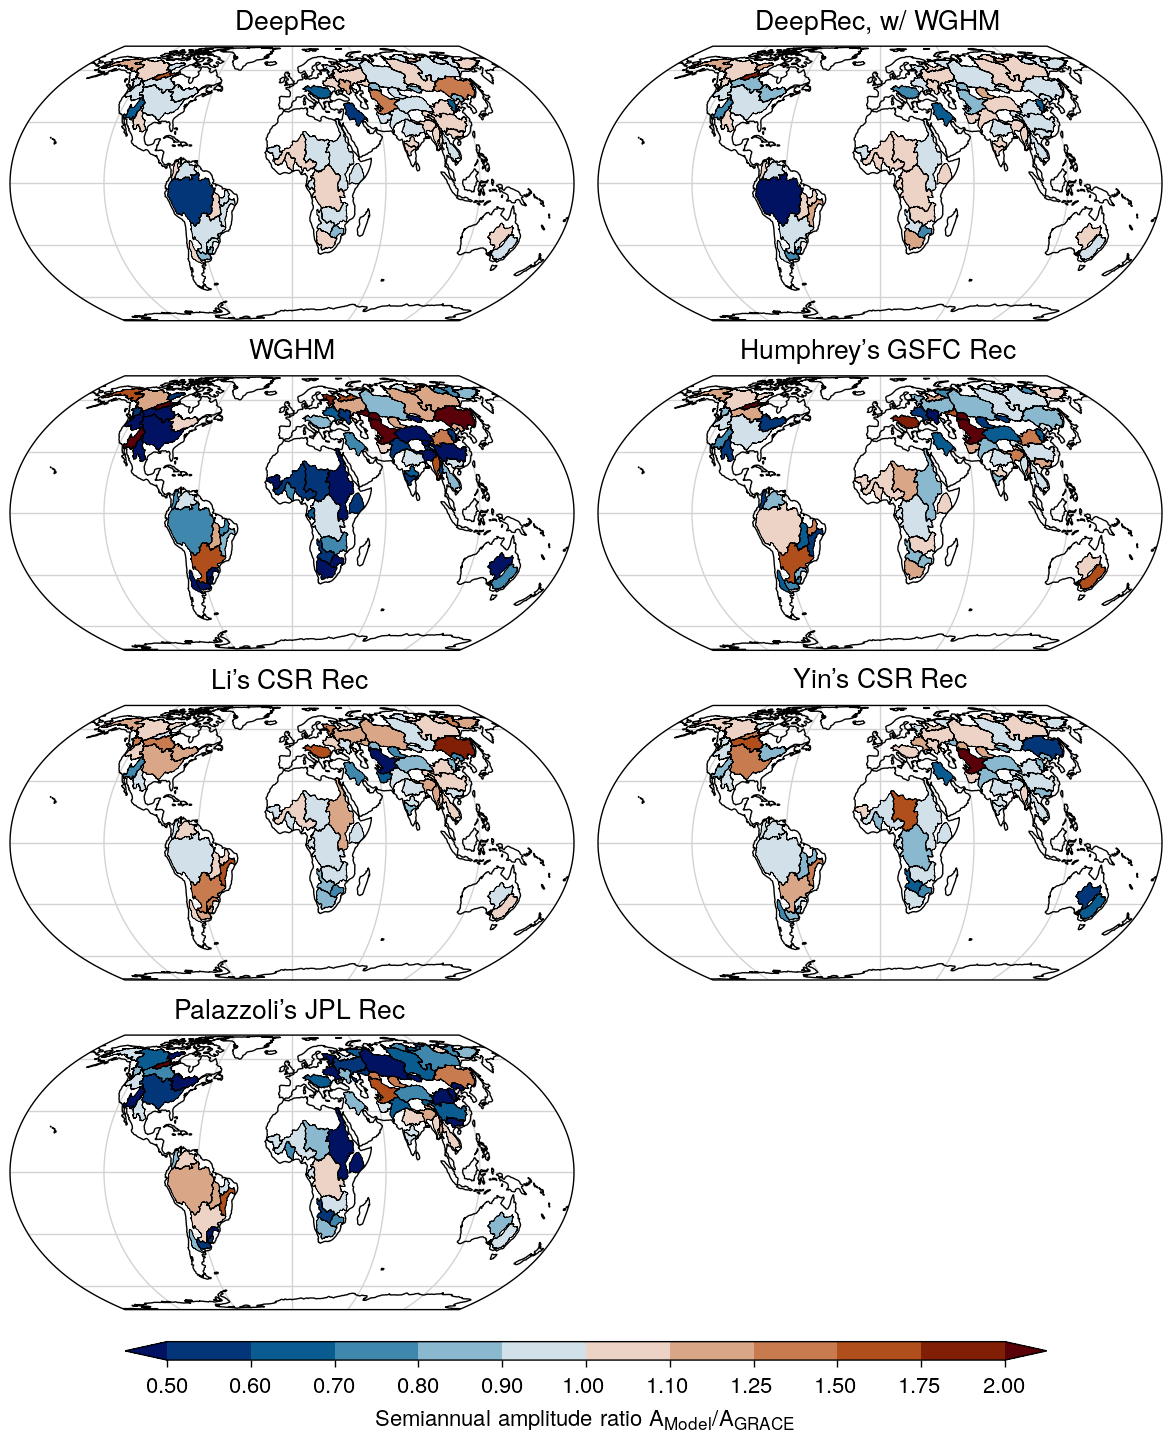

In [32]:
plot_kwargs["cbar_kwargs"]["label"] = (
    r"Semiannual amplitude ratio $A_\text{Model} / A_\text{GRACE}$"
)
plot_kwargs["cbar_kwargs"]["ticks"] = levels

p = amp_semian_ratio.dr.projplot_basins(
    da_grid.drop_sel(model=target_name),
    col="model",
    cmap=cmc.vik,
    levels=levels,
    **plot_kwargs,
)

for ax, model in zip(p.axs.flat, amp_semian_ratio.model.values):
    ax.set_title(names_verbose[model])
    gdf_basin_shapes.dr.projplot(ax=ax, **basinlines_kwargs)

p.fig.savefig(FIGURE_DIR / "decomp_grace-era_amp-semiannual_ratio.pdf", backend="pgf")
